# Imports

In [1]:
%load_ext autoreload

In [2]:
import sys
sys.path.append('/home/hice1/mbibars3/scratch/vlm-debiasing/VLM-Debiasing-Project/scripts')

In [3]:
%autoreload 2
import pandas as pd
import numpy as np
import os
import model as m
import torch
import torch.nn as nn
import torch.optim as optim
import loaders
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Text-Audio-Visual

- text: Roberta
- audio: AST
- visual: densenet features

In [4]:
features_csv = pd.read_csv("/home/hice1/mbibars3/scratch/vlm-debiasing/data/e-daic/audio_text_visual_paths.csv")
features_csv.head()

,split,label,label.1,gender,audio,text,visual
0,train,22.0,0,female,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
1,test,23.0,0,male,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
2,train,19.0,0,male,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
3,train,67.0,1,female,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
4,dev,39.0,0,male,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...


In [6]:
train_loader = loaders.MultiModalityDataset(features_csv[features_csv["split"]=="train"], 
                                            modalities = {"audio", "text"}, label = "label.1")
train_dataloader = DataLoader(train_loader, batch_size=16, collate_fn=loaders.collate_fn)

for batch in train_dataloader:
    modalities, labels = batch
    print(f"Modality 1 shape: {modalities[0].shape}")  # Expected shape: (batch_size, feature, 1)
    print(f"Modality 2 shape: {modalities[1].shape}")
    #print(f"Modality 3 shape: {modalities[2].shape}")
    print(f"Labels shape: {labels}")
    break

Modality 1 shape: torch.Size([16, 768, 1])
Modality 2 shape: torch.Size([16, 768, 1])
Labels shape: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.])


In [7]:
dev_loader = loaders.MultiModalityDataset(features_csv[features_csv["split"]=="dev"], 
                                            modalities = {"audio", "text"}, label = "label.1")
dev_dataloader = DataLoader(train_loader, batch_size=16, collate_fn=loaders.collate_fn)

In [8]:
# Define input dimensions for each modality
input_dims = [768, 768]  # These are the feature dimensions for each modality

# Initialize MultiModalPerceiver model
model = m.MultiModalPerceiver(
    input_dims=input_dims,
    input_channels=1,
    input_axis=1,
    projection_dim=256,
    num_latents=16,
    latent_dim=128,
    depth=8,
    cross_heads=8,
    latent_heads=8,
    cross_dim_head=32,
    latent_dim_head=32,
    attn_dropout=0.5,
    ff_dropout=0.5,
    output_dim=1,
    weight_tie_layers=True,
    fourier_encode_data=False,
    max_freq=10,
    num_freq_bands=4
)

In [9]:
labels_torch = torch.from_numpy(features_csv[features_csv["split"]=="train"]["label.1"].values)

In [10]:
# Calculate class weights
class_counts = torch.bincount(labels_torch)  # Get counts for each class
class_weights = len(labels_torch) / (2.0 * class_counts)

# Apply weights to loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])  # Weight for positive class


In [11]:
class_weights

tensor([0.7149, 1.6633])

In [12]:
learning_rate = 0.01
num_epochs = 10
# Define loss function and optimizer
#criterion = nn.MSELoss()  # Mean Squared Error for regression
# loss function for binary classification
#criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
from sklearn.metrics import f1_score
# Define variables to track losses
train_losses = []
val_losses = []
best_val_loss = float('inf')  # Initialize best validation loss

# Training loop
for epoch in range(num_epochs):
    running_train_loss = 0.0
    all_train_labels = []
    all_train_preds = []
    all_dev_labels = []
    all_dev_preds = []

    for batch in train_dataloader:
        
        # Unpack the batch
        modalities, labels = batch
        modality_1, modality_2 = modalities  # Each has shape (batch_size, feature, 1)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        inputs = [modality_1, modality_2]
        output = model(inputs)

        #print(output, labels)
        # Reshape labels to match the output shape if necessary
        labels = labels.view(output.shape)  # Ensures labels has shape (batch_size, 1)

        # Compute loss
        loss = criterion(output, labels)
        #RMSE_loss = torch.sqrt(loss)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_train_loss += loss.item()
        # Convert logits to predictions
        preds = torch.sigmoid(output) > 0.5
        all_train_labels.extend(labels.cpu().numpy().flatten())
        all_train_preds.extend(preds.cpu().numpy().flatten())

    # Average training loss for the epoch
    train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(train_loss)

    # Validation Phase
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0

    with torch.no_grad():  # Disable gradient computation
        for batch in dev_dataloader:  # Use validation DataLoader
            modalities, labels = batch
            modality_1, modality_2 = modalities

            # Forward pass
            inputs = [modality_1, modality_2]
            output = model(inputs)

            # Reshape labels to match the output shape if necessary
            labels = labels.view(output.shape)

            # Compute loss
            loss = criterion(output, labels)
            #RMSE_loss = torch.sqrt(loss)

            running_val_loss += loss.item()
            preds = torch.sigmoid(output) > 0.5
            all_dev_labels.extend(labels.cpu().numpy().flatten())
            all_dev_preds.extend(preds.cpu().numpy().flatten())

    # Average validation loss for the epoch
    val_loss = running_val_loss / len(dev_dataloader)
    val_losses.append(val_loss)

    # Check if this is the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_aud_text_model.pth")  # Save best model

    # Compute F1-score for training
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
    dev_f1 = f1_score(all_dev_labels, all_dev_preds, average='weighted')

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train F1: {train_f1:.4f}, Val F1: {dev_f1:.4f}")


Epoch [1/10], Train Loss: 1.0765, Val Loss: 0.8532, Train F1: 0.5855, Val F1: 0.1390
Epoch [2/10], Train Loss: 0.9125, Val Loss: 0.9007, Train F1: 0.5721, Val F1: 0.1390
Epoch [3/10], Train Loss: 0.8422, Val Loss: 0.7953, Train F1: 0.5631, Val F1: 0.5757
Epoch [4/10], Train Loss: 0.8096, Val Loss: 0.8097, Train F1: 0.5757, Val F1: 0.5757
Epoch [5/10], Train Loss: 0.8199, Val Loss: 0.7976, Train F1: 0.5757, Val F1: 0.5757
Epoch [6/10], Train Loss: 0.8083, Val Loss: 0.7977, Train F1: 0.5757, Val F1: 0.5757
Epoch [7/10], Train Loss: 0.8133, Val Loss: 0.8007, Train F1: 0.5757, Val F1: 0.5757
Epoch [8/10], Train Loss: 0.8110, Val Loss: 0.7975, Train F1: 0.5757, Val F1: 0.5757
Epoch [9/10], Train Loss: 0.8108, Val Loss: 0.7991, Train F1: 0.5757, Val F1: 0.5757
Epoch [10/10], Train Loss: 0.8106, Val Loss: 0.7978, Train F1: 0.5757, Val F1: 0.5757


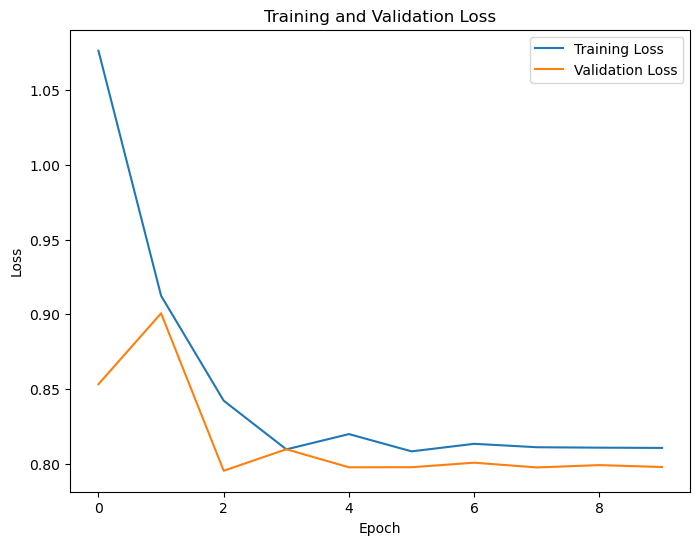

In [14]:
# Plot training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig("loss_plot.png")  # Save the plot
plt.show()

In [15]:
# Model prediction
model.eval()  # Set model to evaluation mode

predictions = []
with torch.no_grad():  # Disable gradient computation
    for batch in dev_dataloader:
        modalities, _ = batch  # Ignore labels if unavailable
        modality_1, modality_2 = modalities
        
        # Forward pass
        inputs = [modality_1, modality_2]
        output = model(inputs)  # Model's prediction
        predictions = torch.sigmoid(output)  # Apply sigmoid activation
        predicted_classes = (predictions > 0.5).int()  # Convert probabilities to binary predictions
        #print(f"Predicted Probabilities:\n{predictions}")
        print(f"Predicted Classes:\n{predicted_classes}")
        # Collect predictions
        #predictions.append(output)

# Combine predictions into a single tensor
#predictions = torch.cat(predicted_classes, dim=0)
#y_pred = np.array(predictions)
#print(f"Predictions:\n{predictions}")

Predicted Classes:
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], dtype=torch.int32)
Predicted Classes:
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], dtype=torch.int32)
Predicted Classes:
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], dtype=torch.int32)
Predicted Classes:
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], dtype=torch.int32)
Predicted Cl

In [30]:
y_test = np.array(features_csv[features_csv["split"]=="dev"]["PTSD_severity"].values)

In [42]:
features_csv['col_encoded'] = features_csv['gender'].map({'female': 0, 'male': 1, None:1})

In [43]:
np.unique(features_csv['col_encoded'])

array([ 0.,  1., nan])

In [44]:
from fairlearn.metrics import demographic_parity_difference

# Assuming `gender` corresponds to the original metadata
# Split the dataset into training and testing sets for `gender`
gender_train, gender_test = features_csv[features_csv["split"]=="train"]["col_encoded"], features_csv[features_csv["split"]=="dev"]["col_encoded"]

# Ensure that `gender_test`, `y_test`, and `y_pred` are aligned
print(f"Shape of gender_test: {gender_test.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")



Shape of gender_test: (56,)
Shape of y_test: (56,)
Shape of y_pred: (56, 1)


In [46]:
gender_test

4      1.0
5      NaN
6      0.0
11     1.0
14     1.0
15     1.0
24     1.0
29     1.0
30     0.0
32     1.0
36     1.0
43     0.0
46     1.0
54     1.0
61     0.0
66     1.0
72     0.0
74     0.0
76     1.0
77     0.0
80     0.0
81     1.0
89     1.0
94     1.0
103    0.0
111    0.0
119    0.0
124    1.0
126    1.0
138    1.0
143    0.0
147    0.0
149    0.0
150    1.0
158    1.0
163    1.0
164    0.0
167    1.0
172    1.0
184    0.0
189    1.0
190    0.0
193    1.0
197    1.0
206    0.0
208    1.0
212    1.0
223    1.0
234    1.0
238    1.0
239    1.0
247    0.0
249    0.0
253    1.0
268    1.0
269    1.0
Name: col_encoded, dtype: float64

In [47]:
# Calculate Demographic Parity Difference
demographic_parity = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred[:,0],
    sensitive_features=gender_test
)

print(f"Demographic Parity Difference: {demographic_parity}")

Demographic Parity Difference: 0.0


In [33]:
from fairlearn.metrics import MetricFrame, selection_rate
metric_frame = MetricFrame(metrics=selection_rate, 
                           y_true=y_test, 
                           y_pred=y_pred[:,0], 
                           sensitive_features=gender_test)

# Get selection rates for each group
selection_rates = metric_frame.by_group
print("Selection Rates by Group:")
print(selection_rates)


Selection Rates by Group:
gender
female     0.0
male       0.0
unknown    0.0
Name: selection_rate, dtype: float64


In [34]:
group_a_rate = selection_rates[1]
group_b_rate = selection_rates[0]

if group_b_rate > 0:  # Avoid division by zero
    demographic_parity_ratio = group_a_rate / group_b_rate
    print(f"Demographic Parity Ratio: {demographic_parity_ratio}")

/scratch/954025/ipykernel_2837344/1510568790.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  group_a_rate = selection_rates[1]
/scratch/954025/ipykernel_2837344/1510568790.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  group_b_rate = selection_rates[0]
